In [192]:
# First approach to Smart Charging Phase 1 using PuLP.
# Modeled as a PuLP optimisation blending problem
# Started 20 Aug 2020
# Author: Sofia Taylor, Flexible Power Systems

import numpy as np
import pandas as pd
import datetime as dt
from pulp import *
import pickle
import global_variables as gv
import functions as f
import matplotlib.pyplot as plt

In [210]:
# Import journey and price data

prot_journeys = pickle.load(open('Data/prototype_week','rb'))
test_journeys = pickle.load(open('Data/test_week','rb'))
electricity_price = pickle.load(open('Data/price_data','rb'))
BAU_profile = pickle.load(open('Data/BAU_profile','rb'))

BAU_profile['Site_output'] = BAU_profile[gv.Power_output.values()].sum(axis=1)
BAU_profile['Electricity_costs'] = BAU_profile['Site_output'] * BAU_profile['unit_rate_excl_vat']

In [211]:
BAU_profile.head(10)

,date,from,to,unit_rate_excl_vat,Output_0,SOC_0,Output_1,SOC_1,Output_2,SOC_2,...,Output_6,SOC_6,Output_7,SOC_7,Output_8,SOC_8,Output_9,SOC_9,Site_output,Electricity_costs
0,2020/02/10,2020-02-10 11:00:00,2020-02-10 11:30:00,12.26,0.000000,47.582503,0.0000,49.650865,0.000000,49.427728,...,0.000000,48.932328,0.000000,48.794687,0.0000,47.310869,0.000000,49.311190,0.000000,0.000000
1,2020/02/10,2020-02-10 11:30:00,2020-02-10 12:00:00,12.02,0.000000,47.582503,0.0000,49.650865,0.000000,49.427728,...,0.000000,48.932328,0.000000,48.794687,0.0000,47.310869,0.000000,49.311190,0.000000,0.000000
2,2020/02/10,2020-02-10 12:00:00,2020-02-10 12:30:00,11.60,0.000000,47.582503,0.0000,49.650865,0.000000,49.427728,...,2.030000,50.962328,0.000000,48.794687,0.0000,47.310869,0.000000,49.311190,3.818889,44.299111
3,2020/02/10,2020-02-10 12:30:00,2020-02-10 13:00:00,11.36,0.000000,47.582503,0.0000,49.650865,0.000000,49.427728,...,3.500000,54.462328,2.195278,50.989965,3.3075,50.618369,3.418333,52.729523,19.421111,220.623822
4,2020/02/10,2020-02-10 13:00:00,2020-02-10 13:30:00,8.96,0.789444,48.371947,1.9075,51.558365,3.111111,52.538839,...,3.500000,57.962328,3.500000,54.489965,3.5000,54.118369,3.500000,56.229523,26.808056,240.200178
5,2020/02/10,2020-02-10 13:30:00,2020-02-10 14:00:00,8.76,3.500000,51.871947,3.5000,55.058365,3.500000,56.038839,...,3.500000,61.462328,3.500000,57.989965,3.5000,57.618369,3.500000,59.729523,31.500000,275.940000
6,2020/02/10,2020-02-10 14:00:00,2020-02-10 14:30:00,8.78,3.500000,55.371947,3.5000,58.558365,3.500000,59.538839,...,3.500000,64.962328,3.500000,61.489965,3.5000,61.118369,3.500000,63.229523,31.500000,276.570000
7,2020/02/10,2020-02-10 14:30:00,2020-02-10 15:00:00,8.76,3.500000,58.871947,3.5000,62.058365,3.500000,63.038839,...,3.500000,68.462328,3.500000,64.989965,3.5000,64.618369,3.500000,66.729523,31.500000,275.940000
8,2020/02/10,2020-02-10 15:00:00,2020-02-10 15:30:00,8.68,3.500000,62.371947,3.5000,65.558365,3.500000,66.538839,...,3.500000,71.962328,3.500000,68.489965,3.5000,68.118369,3.500000,70.229523,32.481944,281.943278
9,2020/02/10,2020-02-10 15:30:00,2020-02-10 16:00:00,8.96,3.500000,65.871947,3.5000,69.058365,3.500000,70.038839,...,3.037672,75.000000,3.500000,71.989965,3.5000,71.618369,3.500000,73.729523,34.537672,309.457543


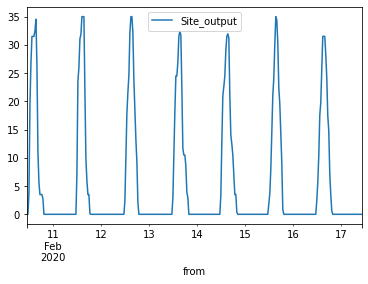

In [212]:
plot = BAU_profile.plot(x='from', y='Site_output', kind='line')
fig = plot.get_figure()
fig.savefig('Data/BAU_profile_output.png')

In [213]:
# Start with one vehicle only, just look for cheapest slots

# Creates a list of the time periods
start_datetime = BAU_profile.iloc[0,1]
end_datetime = start_datetime + dt.timedelta(days=1)
day_profile = BAU_profile[BAU_profile['from'] < end_datetime][['from','Output_1']]
day_profile = day_profile.merge(electricity_price[['from','unit_rate_excl_vat']], on='from')

#time_periods = day_profile['from'].to_numpy()
time_periods = list(day_profile.index)

# Create a dictionary of price costs
prices = day_profile.unit_rate_excl_vat.to_dict()

# Get required charge for the day
day = dt.datetime(2020,2,10)
vehicle = 1
required_charge = prot_journeys.loc[(day, vehicle),'Required_SOC']
day

datetime.datetime(2020, 2, 10, 0, 0)

In [214]:
prot_journeys.head()

Route_ID Branch_ID Start_Time_of_Route  \
date       Vehicle_ID                                           
2020-02-10 0           10296307       122            06:49:18   
           1           10296306       122            06:58:52   
           2           10296309       122            07:09:12   
           3           10296308       122            08:50:57   
           4           10550506       213            06:35:25   

                      End_Time_of_Route Planned_total_Mileage Required_SOC  
date       Vehicle_ID                                                       
2020-02-10 0                   13:06:46               68.6019      27.4175  
           1                   13:16:21               68.6019      25.3491  
           2                   13:26:40               68.6019      25.5723  
           3                   15:08:25               68.6019      28.2256  
           4                   12:04:50               70.6388      26.5146

In [215]:
day_profile.head()

,from,Output_1,unit_rate_excl_vat
0,2020-02-10 11:00:00,0.0000,12.26
1,2020-02-10 11:30:00,0.0000,12.02
2,2020-02-10 12:00:00,0.0000,11.60
3,2020-02-10 12:30:00,0.0000,11.36
4,2020-02-10 13:00:00,1.9075,8.96


In [216]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("Single_vehicle_scheduling",LpMinimize)

# A dictionary called 'power_vars' is created to contain the referenced Variables
power_vars = LpVariable.dicts("Power",time_periods,0,3.5)

In [217]:
# The objective function is added to 'prob' first
prob += lpSum([prices[i]*power_vars[i] for i in time_periods]), "Total Charging costs"

# The constraints are added to 'prob'
prob += lpSum([power_vars[i] for i in time_periods]) == required_charge, "Required SOC"



In [218]:
prob

Single_vehicle_scheduling:
MINIMIZE
12.26*Power_0 + 12.02*Power_1 + 21.08*Power_10 + 24.0*Power_11 + 26.0*Power_12 + 28.4*Power_13 + 28.8*Power_14 + 26.4*Power_15 + 14.36*Power_16 + 12.96*Power_17 + 12.8*Power_18 + 10.0*Power_19 + 11.6*Power_2 + 11.8*Power_20 + 10.4*Power_21 + 8.66*Power_22 + 8.8*Power_23 + 8.68*Power_24 + 8.68*Power_25 + 8.68*Power_26 + 10.0*Power_27 + 10.2*Power_28 + 9.6*Power_29 + 11.36*Power_3 + 9.92*Power_30 + 9.92*Power_31 + 9.6*Power_32 + 9.2*Power_33 + 9.2*Power_34 + 9.2*Power_35 + 9.4*Power_36 + 10.0*Power_37 + 11.4*Power_38 + 10.8*Power_39 + 8.96*Power_4 + 9.6*Power_40 + 12.8*Power_41 + 12.8*Power_42 + 12.6*Power_43 + 13.2*Power_44 + 12.0*Power_45 + 12.2*Power_46 + 11.2*Power_47 + 8.76*Power_5 + 8.78*Power_6 + 8.76*Power_7 + 8.68*Power_8 + 8.96*Power_9 + 0.0
SUBJECT TO
Required_SOC: Power_0 + Power_1 + Power_10 + Power_11 + Power_12 + Power_13
 + Power_14 + Power_15 + Power_16 + Power_17 + Power_18 + Power_19 + Power_2
 + Power_20 + Power_21 + Power_22 + Powe

In [219]:
# The problem data is written to an .lp file
prob.writeLP("Models/single_vehicle.lp")

# The problem is solved using PuLP's choice of Solver
prob.solve()

# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

# Each of the variables is printed with it's resolved optimum value
varsdict = {}
for v in prob.variables():
    print(v.name, "=", v.varValue)

for i in range(len(prob.variables())): #FIXME add to previous loop
    #print(i,power_vars[i],power_vars[i].value())
    day_profile.loc[i,'Opt_output'] = power_vars[i].value()

# The optimised objective function value is printed to the screen
print("Total Cost of Electrivity = ", value(prob.objective))

Status: Optimal
Power_0 = 0.0
Power_1 = 0.0
Power_10 = 0.0
Power_11 = 0.0
Power_12 = 0.0
Power_13 = 0.0
Power_14 = 0.0
Power_15 = 0.0
Power_16 = 0.0
Power_17 = 0.0
Power_18 = 0.0
Power_19 = 0.0
Power_2 = 0.0
Power_20 = 0.0
Power_21 = 0.0
Power_22 = 3.5
Power_23 = 0.0
Power_24 = 3.5
Power_25 = 3.5
Power_26 = 3.5
Power_27 = 0.0
Power_28 = 0.0
Power_29 = 0.0
Power_3 = 0.0
Power_30 = 0.0
Power_31 = 0.0
Power_32 = 0.0
Power_33 = 0.0
Power_34 = 0.0
Power_35 = 0.0
Power_36 = 0.0
Power_37 = 0.0
Power_38 = 0.0
Power_39 = 0.0
Power_4 = 0.0
Power_40 = 0.0
Power_41 = 0.0
Power_42 = 0.0
Power_43 = 0.0
Power_44 = 0.0
Power_45 = 0.0
Power_46 = 0.0
Power_47 = 0.0
Power_5 = 3.5
Power_6 = 0.8491346
Power_7 = 3.5
Power_8 = 3.5
Power_9 = 0.0
Total Cost of Electrivity =  220.605401788


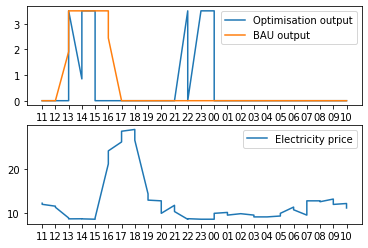

In [244]:
fig, axs = plt.subplots(2)
x = day_profile['from'].dt.strftime('%H')
y = day_profile['Opt_output']
prices = day_profile['unit_rate_excl_vat']
axs[0].plot(x, y, label='Optimisation output')

axs[0].plot(x, day_profile['Output_1'], label='BAU output')
axs[1].plot(x, day_profile['unit_rate_excl_vat'], label = 'Electricity price')
ax.plot(x, day_profile['Output_1'])
axs[0].legend()
axs[1].legend()
fig.show()
fig.savefig('Data/singe_veh.jpg')

In [221]:
day_profile

,from,Output_1,unit_rate_excl_vat,Opt_output
0,2020-02-10 11:00:00,0.000000,12.26,0.000000
1,2020-02-10 11:30:00,0.000000,12.02,0.000000
2,2020-02-10 12:00:00,0.000000,11.60,0.000000
3,2020-02-10 12:30:00,0.000000,11.36,0.000000
4,2020-02-10 13:00:00,1.907500,8.96,0.000000
5,2020-02-10 13:30:00,3.500000,8.76,3.500000
6,2020-02-10 14:00:00,3.500000,8.78,0.849135
7,2020-02-10 14:30:00,3.500000,8.76,3.500000
8,2020-02-10 15:00:00,3.500000,8.68,3.500000
9,2020-02-10 15:30:00,3.500000,8.96,0.000000


In [241]:

x = day_profile['from'].dt.strftime('%H:%M')
x

0     11:00
1     11:30
2     12:00
3     12:30
4     13:00
5     13:30
6     14:00
7     14:30
8     15:00
9     15:30
10    16:00
11    16:30
12    17:00
13    17:30
14    18:00
15    18:30
16    19:00
17    19:30
18    20:00
19    20:30
20    21:00
21    21:30
22    22:00
23    22:30
24    23:00
25    23:30
26    00:00
27    00:30
28    01:00
29    01:30
30    02:00
31    02:30
32    03:00
33    03:30
34    04:00
35    04:30
36    05:00
37    05:30
38    06:00
39    06:30
40    07:00
41    07:30
42    08:00
43    08:30
44    09:00
45    09:30
46    10:00
47    10:30
Name: from, dtype: object